In [1]:
# Run 'source ~/.profile'
import satpy
from satpy import Scene, find_files_and_readers
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyresample import geometry
from pyproj import CRS
from satpy.composites import GenericCompositor
from satpy.writers import to_image
import os

import datetime

sys.path.insert(0,'/home/cameron/Projects/')


# ====== Configuration =======

# Place .nc and .points (GCPs) files in the capture_directory. 
# NB: Filenames should match the same pattern. For example: erie_2022-07-19_1550Z-l1a.nc and erie_2022-07-19_1550Z-bin3.points.
capture_directory = '/home/cameron/Dokumenter/Data/erie'
capture_directory = '/home/cameron/Dokumenter/Data/svalbardeidembukta/temp'

nc_file = '/home/cameron/Dokumenter/Data/svalbardeidembukta/svalbardeidembukta_2023-03-16_1214Z-l1a.nc'
points_file = '/home/cameron/Dokumenter/Data/svalbardeidembukta/svalbardeidembukta_2023-03-16_1214Z-bin3.points'

# Define area of interest
bbox = (-83.534546, 41.356196, -81.359009, 42.706660) # W. Lake Erie
bbox = (13.364868, 77.401491, 17.265015, 77.915669) # Van Mijenfjorden

# Specified resample image resolution:
resolution = (500,500)

def get_area(scene, bbox=None, resolution=(500,500)):

    if bbox == None:
        grid_lats = scene['band_80'].attrs['area'].lats.data
        grid_lons = scene['band_80'].attrs['area'].lons.data   

        # Is there a function that can do this? Possibly in pyresample.
        lon_min = grid_lons.min()
        lon_max = grid_lons.max()
        lat_min = grid_lats.min()
        lat_max = grid_lats.max()

        bbox = (lon_min,lat_min,lon_max,lat_max)

    area_id = 'roi'
    proj_id = 'roi'
    description = 'roi'
    projection = CRS.from_epsg(4326)
    width = resolution[0]
    height = resolution[1]
    area_extent = list(bbox)

    # Define area definition
    area_def = geometry.AreaDefinition(area_id, proj_id, description, projection,  width, height, area_extent)

    return area_def

def write_composites(scene, resampled_scene, name, gamma=2):

    # Original capture composite
    s = scene
    compositor = GenericCompositor("overview")
    composite = compositor([s['band_80'][:,::3], s['band_40'][:,::3], s['band_15'][:,::3]]) # Red, Green, Blue
    #composite = composite[:,:,::-1] # correct for composite mirroring
    img = to_image(composite[:,:,::-1]) 
    img.invert([False, False, False])
    img.stretch("linear")
    img.gamma([gamma, gamma, gamma])
    img.save('./composites_out/' + name + '.png')

    # Resampled capture composites
    s = resampled_scene
    compositor = GenericCompositor("overview")
    composite = compositor([s['band_80'], s['band_40'], s['band_15']]) # Red, Green, Blue
    img = to_image(composite)
    img.invert([False, False, False])
    img.stretch("linear")
    img.gamma([gamma, gamma, gamma])
    img.save('./composites_out/resampled_' + name + '.png')

def write_nc(scene, datasets, name):

    scene.save_datasets(writer='cf', 
                        datasets=datasets, 
                        filename = './datasets_out/' + name + '.nc')


In [2]:

files = [nc_file, points_file]

scene = Scene(filenames=files, reader='hypso1_l1a_nc', reader_kwargs={'flip': True})
datasets = scene.available_dataset_names()

#scene.load(datasets)
scene.load(['latitude', 'longitude', 'band_80', 'band_40', 'band_15'])

area_def = get_area(scene, bbox=bbox, resolution=resolution)

resampled_scene = scene.resample(area_def, resampler='bilinear', fill_value=np.NaN)

[INFO] Flip status:
True


/home/cameron/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [3]:
scene.available_composite_names()

['overview']

In [6]:
scene.load(['overview'])

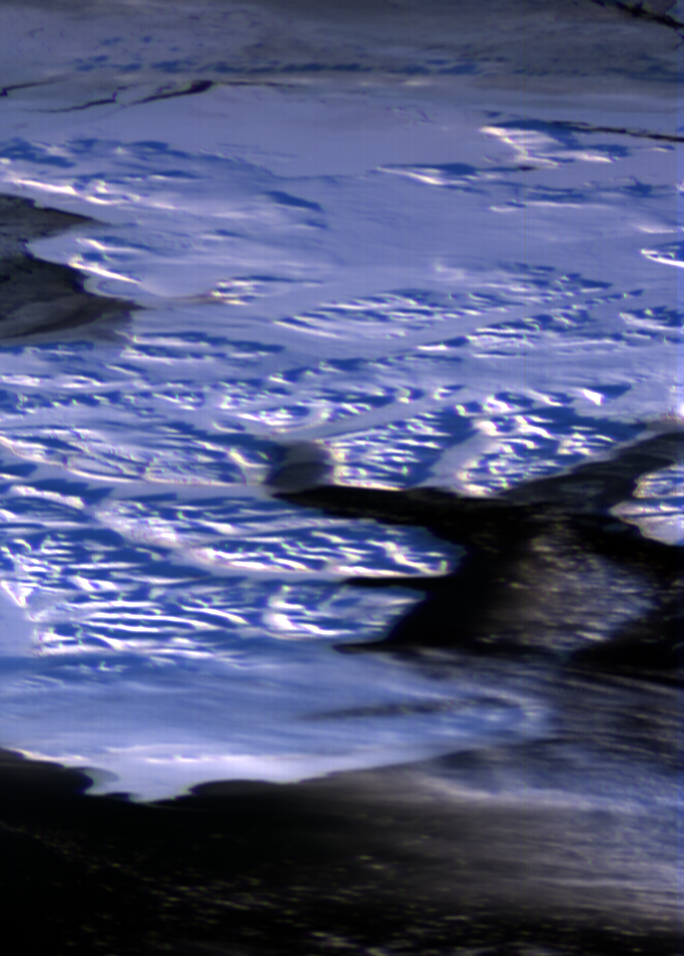

In [7]:
scene.show('overview')

In [4]:
lons, lats = resampled_scene["band_80"].attrs["area"].get_lonlats()

In [5]:
lons.shape

(500, 500)

In [4]:
list(resampled_scene.keys())

[DataID(name='band_15', wavelength=441, modifiers=()),
 DataID(name='band_40', wavelength=529, modifiers=()),
 DataID(name='band_80', wavelength=669, modifiers=()),
 DataID(name='latitude', modifiers=()),
 DataID(name='longitude', modifiers=())]

In [3]:
s = resampled_scene
compositor = GenericCompositor("overview")
composite = compositor([s['band_80'], s['band_40'], s['band_15']]) # Red, Green, Blue


In [5]:
type(composite)

xarray.core.dataarray.DataArray